# K-Means Clustering and PCA to categorize music by similar audio features
### Using unsupervised machine learning to organize my music

March 23rd, 2020. I was on my way to work pressed up against the tube doors speeding along the northern line on the London underground listenting to my carefully curated playlists. A fairly typical day for me, until I stepped out of the tube station onto liverpool street where my phone could finally get some signal and received a sequence messages from friends, family and 1 


## Data Acquisition via Spotify API
The Spotify Developer API allows you to get audio features for a track. These features are described in more detail below:
- **acousticness**: [0–1] Confidence measure of whether the track is acoustic.
- **danceability**: [0–1] Describes how suitable a track is for dancing based on musical attributes including tempo, rhythm, stability, beat strength, and overall regularity.
- **energy**: [0–1] Perceptual measure of intensity and activity. Energetic tracks feel fast, loud, and noisy (e.g. death metal: high energy, Bach prelude: low energy).
- **instrumentalness****: [0–1] Predicts whether a track contains no vocals (values above 0.5 represent instrumental tracks whereas rap songs would have a score close to 0).
- **liveness**: [0–1] Detects the presence of an audience in the recording.
- **loudness**: [-60–0 dB] The average volume across an entire track.
- **speechiness**: [0–1] Detects the presence of spoken words in a track (values above 0.66 describe tracks that are probably made entirely of spoken words, 0.33–0.66 describe tracks that may contain both music and speech, and values below 0.33 most likely represent music and other non-speech-like tracks).
- **valence**: [0–1] Describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- **tempo**: [0–300 BPM] The speed or pace of a given piece, as derived from the estimated average beat duration.

I use Spotipy, which is a Python wrapper for Spotify’s Developer API. First, we must create a token with our API credentials.

In [31]:
!pip install requests

In [266]:
import base64
import requests
import datetime
from urllib.parse import urlencode
import json
import pandas as pd
import time
import matplotlib.pyplot as plt

In [203]:
client_id = "fc59169250d744ea802e99ef44eda8b0"
client_secret = "8ab9e358488e4751a3709b0d78d1dc41"
user_id = "rhun515"

In [204]:
class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"
    
    def __init__(self, client_id, client_secret, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_id = client_id
        self.client_secret = client_secret

    def get_client_credentials(self):
        """
        Returns a base64 encoded string
        """
        client_id = self.client_id
        client_secret = self.client_secret
        if client_secret == None or client_id == None:
            raise Exception("You must set client_id and client_secret")
        client_creds = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()
    
    def get_token_headers(self):
        client_creds_b64 = self.get_client_credentials()
        return {
            "Authorization": f"Basic {client_creds_b64}"
        }
    
    def get_token_data(self):
        return {
            "grant_type": "client_credentials"
        } 
    
    def perform_auth(self):
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_headers()
        r = requests.post(token_url, data=token_data, headers=token_headers)
        if r.status_code not in range(200, 299):
            raise Exception("Could not authenticate client.")
            # return False
        data = r.json()
        now = datetime.datetime.now()
        access_token = data['access_token']
        expires_in = data['expires_in'] # seconds
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now
        return True
    
    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token() 
        return token
    
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}"
        }
        return headers
        
        
    def get_resource(self, lookup_id, resource_type='albums', version='v1'):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    def get_album(self, _id):
        return self.get_resource(_id, resource_type='albums')
    
    def get_artist(self, _id):
        return self.get_resource(_id, resource_type='artists')
    
    def search(self, query, search_type='artist' ): # type
        headers = self.get_resource_header()
        endpoint = "https://api.spotify.com/v1/search"
        data = urlencode({"q": query, "type": search_type.lower()})
        lookup_url = f"{endpoint}?{data}"
        r = requests.get(lookup_url, headers=headers)
        if r.status_code not in range(200, 299):  
            return {}
        return r.json()
    
    def get_user_playlists(self, user_id, resource_type = 'playlists', version='v1'):
        endpoint = f"https://api.spotify.com/{version}/users/{user_id}/{resource_type}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    def get_playlist_tracks(self, playlist_uri, version='v1'):
        endpoint = f"https://api.spotify.com/{version}/playlists/{playlist_uri}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    def get_track_audio_features(self, track_id, version='v1'):
        endpoint = f"https://api.spotify.com/v1/audio-features/{track_id}"
        headers = self.get_resource_header()
        time.sleep(1)
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()

In [205]:
spotify = SpotifyAPI(client_id, client_secret)

In [206]:
def get_user_playlists(spotify_client,user_id):
    # initialize vars
    playlists = {}
    
    # retrieve playlists for user using our api client
    playlist_dict = spotify_client.get_user_playlists(user_id)

    for playlist in playlist_dict['items']:
        playlists[playlist['name']] = playlist['id']
        
    return playlists


In [207]:
def get_playlist_tracks(spotify_client,playlists):
    # initialize vars
    playlist_name, track_id, track_name, track_artist = [], [], [], []
    
    for name in playlists:
        playlist_tracks = spotify_client.get_playlist_tracks(playlists[name])['tracks']['items']
        # iterate through each track in the playlist and store the track ID, track name and track artist
        for track in playlist_tracks:
            playlist_name = name
            track_id.append(track['track']['id'])
            track_name.append(track['track']['name'])
            track_artist.append(track['track']['artists'][0]['name'])
       
    df = {'playlist_name':playlist_name,'track_id':track_id,'track_name':track_name,'track_artist':track_artist}
    
    return pd.DataFrame(df)

In [230]:
def get_features_for_tracks(spotify_client, track_ids):
    # initialize vars
    features = []
    
    for id in track_ids:
        audio_features = spotify_client.get_track_audio_features(id)
        
        # safely try to retrieve features from the spotify api response using .get to avoid key error for tracks which don't have certain features
        danceability = audio_features.get('danceability')
        energy = audio_features.get('energy')
        key = audio_features.get('key')
        loudness = audio_features.get('loudness')
        mode = audio_features.get('mode')
        speechiness = audio_features.get('speechiness')
        acousticness = audio_features.get('acousticness')
        instrumentalness = audio_features.get('instrumentalness')
        liveness = audio_features.get('liveness')
        valence = audio_features.get('valence')
        tempo = audio_features.get('tempo')
        
        features += [[id,
        danceability,
        energy,
        key,
        loudness,
        mode,
        speechiness,
        acousticness,
        instrumentalness,
        liveness,
        valence,
        tempo]]
        
    return pd.DataFrame(features)

In [221]:
def combine_data(spotify_client, user_id):
    # get user playlists
    playlists = get_user_playlists(spotify_client, user_id)
    
    # get playlist track info such as id, name, artisit
    playlist_tracks = get_playlist_tracks(spotify_client, playlists)

    # get track audio features
    audio_features = get_features_for_tracks(spotify_client, playlist_tracks['track_id'])
    
    return playlist_tracks, audio_features

In [231]:
track_info, audio_features = combine_data(spotify, user_id)

In [238]:
combined_data = tmp1.join(audio_features, how='inner', lsuffix='track_id',rsuffix='0')

In [243]:
combined_data.drop(columns=['playlist_name',0], inplace=True)

In [246]:
combined_data.head()

,track_id,track_name,track_artist,1,2,3,4,5,6,7,8,9,10,11
0,1HbA4N1MiOsPthALesGFR1,Monster (Shawn Mendes & Justin Bieber),Shawn Mendes,0.640,0.392,2.0,-7.246,0.0,0.0574,0.0593,0.000000,0.0839,0.502,145.838
1,6ZuahEctZD6w75peme58hm,Wonder,Shawn Mendes,0.442,0.631,1.0,-5.096,0.0,0.0500,0.1360,0.000023,0.1330,0.129,139.774
2,6v3KW9xbzN5yKLt9YKDYA2,Señorita,Shawn Mendes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3QGsuHI8jO1Rx4JWLUh9jd,Treat You Better,Shawn Mendes,0.444,0.819,10.0,-4.078,0.0,0.3410,0.1060,0.000000,0.1070,0.747,82.695
4,7JJmb5XwzOO8jgpou264Ml,There's Nothing Holdin' Me Back,Shawn Mendes,0.866,0.813,11.0,-4.063,0.0,0.0554,0.3800,0.000000,0.0779,0.969,121.998


In [320]:
clean_data = combined_data.dropna(axis=0)


In [321]:
clean_data.head()

,track_id,track_name,track_artist,1,2,3,4,5,6,7,8,9,10,11
0,1HbA4N1MiOsPthALesGFR1,Monster (Shawn Mendes & Justin Bieber),Shawn Mendes,0.640,0.392,2.0,-7.246,0.0,0.0574,0.0593,0.000000,0.0839,0.502,145.838
1,6ZuahEctZD6w75peme58hm,Wonder,Shawn Mendes,0.442,0.631,1.0,-5.096,0.0,0.0500,0.1360,0.000023,0.1330,0.129,139.774
3,3QGsuHI8jO1Rx4JWLUh9jd,Treat You Better,Shawn Mendes,0.444,0.819,10.0,-4.078,0.0,0.3410,0.1060,0.000000,0.1070,0.747,82.695
4,7JJmb5XwzOO8jgpou264Ml,There's Nothing Holdin' Me Back,Shawn Mendes,0.866,0.813,11.0,-4.063,0.0,0.0554,0.3800,0.000000,0.0779,0.969,121.998
5,5LZtB6nxvjIhUoElp3Zqk0,Teach Me How To Love,Shawn Mendes,0.592,0.885,9.0,-4.944,0.0,0.0807,0.0505,0.000002,0.0843,0.731,98.991


In [322]:
from sklearn.preprocessing import StandardScaler

num_features = clean_data.select_dtypes(include=['float64'])

scaler = StandardScaler()
std_data = scaler.fit_transform(num_features)

[[ 0.35352724 -1.24942106 -0.95008132 ... -0.67210389  0.25769701
   0.71062692]
 [-1.06964452 -0.0558187  -1.22800655 ... -0.30875072 -1.32086968
   0.51416448]
 [-1.05526905  0.88308191  1.27332044 ... -0.50115769  1.29455717
  -1.33509005]
 ...
 [-0.72463319 -0.065807   -0.95008132 ... -0.58478072 -0.59718361
  -1.58546302]
 [-0.62400488  0.03407604  0.16161956 ... -0.60402142 -1.72545674
  -1.19532439]
 [-1.01933037  1.27761993  0.16161956 ...  0.66068442 -0.78339523
   1.62325066]]


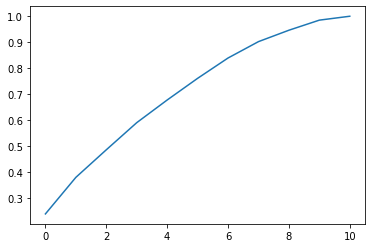

In [323]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(std_data)
evr = pca.explained_variance_ratio_
plt.plot(evr.cumsum())
plt.show()

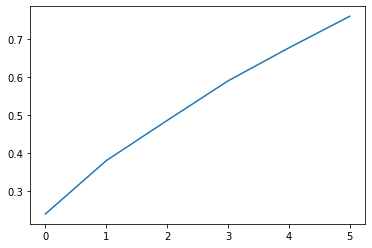

In [324]:
pca = PCA(n_components=6)
pca.fit(std_data)
evr = pca.explained_variance_ratio_
plt.plot(evr.cumsum())
plt.show()

scores_pca = pca.transform(std_data)

In [270]:
!pip install kneed

Optimal number of clusters 7


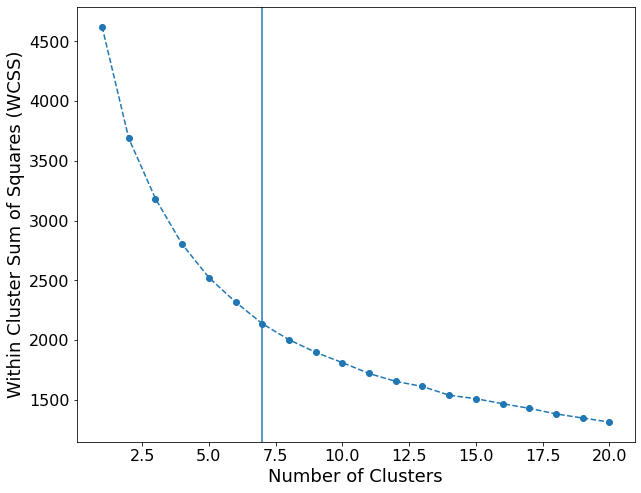

In [325]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

# get within cluster sum of squares for each value of k
wcss = []
max_clusters = 21
for i in range(1, max_clusters):
    kmeans_pca = KMeans(i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)
      
# programmatically locate the elbow
n_clusters = KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee
print("Optimal number of clusters", n_clusters)
    
# visualize the curve in order to locate the elbow
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
# plt.vlines(n_clusters, ymin=0, ymax=max(wcss), linestyles='dashed')
plt.xlabel('Number of Clusters', fontsize=18)
plt.ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(x=7)
plt.show()

In [331]:
kmeans_pca = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)
cluster_labels = pd.Series(kmeans_pca.labels_).rename('cluster')


In [348]:
track_info = pd.DataFrame(clean_data[['track_id','track_name','track_artist']])

col_map = {0:'danceability',
        1:'energy',
        2:'key',
        3:'loudness',
        4:'mode',
        5:'speechiness',
        6:'acousticness',
        7:'instrumentalness',
        8: 'liveness',
        9:'valence',
        10:'tempo'}

std_data = pd.DataFrame(std_data).rename(columns=col_map)
tracks_with_cluster = pd.concat([track_info, std_data,cluster_labels],axis=1).dropna(axis=0)

In [424]:
average_features_by_group = tracks_with_cluster.select_dtypes(include=['float64']).groupby('cluster').mean()
average_features_by_group.reset_index(drop=False, inplace=True)
average_features_by_group

,cluster,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.0,0.791979,-0.221692,-0.956327,-0.304108,0.332651,-0.272635,0.030704,-0.211522,-0.387676,0.640976,-0.542046
1,1.0,-0.862854,0.742849,-0.069985,0.771380,-0.415181,-0.153447,-0.655604,-0.136990,-0.157832,-0.677049,0.659750
2,2.0,-0.048695,0.587820,-0.093771,0.411020,0.619860,-0.115741,-0.270935,-0.261480,1.469414,0.647672,0.077133
3,3.0,0.642126,-0.493791,-0.234213,-0.372250,-0.156451,3.126574,0.586644,-0.097618,-0.053935,0.277831,0.567193
4,4.0,-0.263866,-1.455424,0.126071,-1.185062,0.245524,-0.289104,1.396398,-0.213072,-0.266079,-0.511838,-0.286808
5,5.0,-0.399202,0.678494,-0.001302,0.333814,0.154713,-0.292667,-0.338738,3.724438,0.310014,-0.588822,0.440592
6,6.0,0.554714,0.081254,0.927938,0.090223,-0.447660,-0.185592,-0.282891,-0.295863,-0.361695,0.361239,-0.454718


In [425]:
!pip install pygal

In [426]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
import pygal

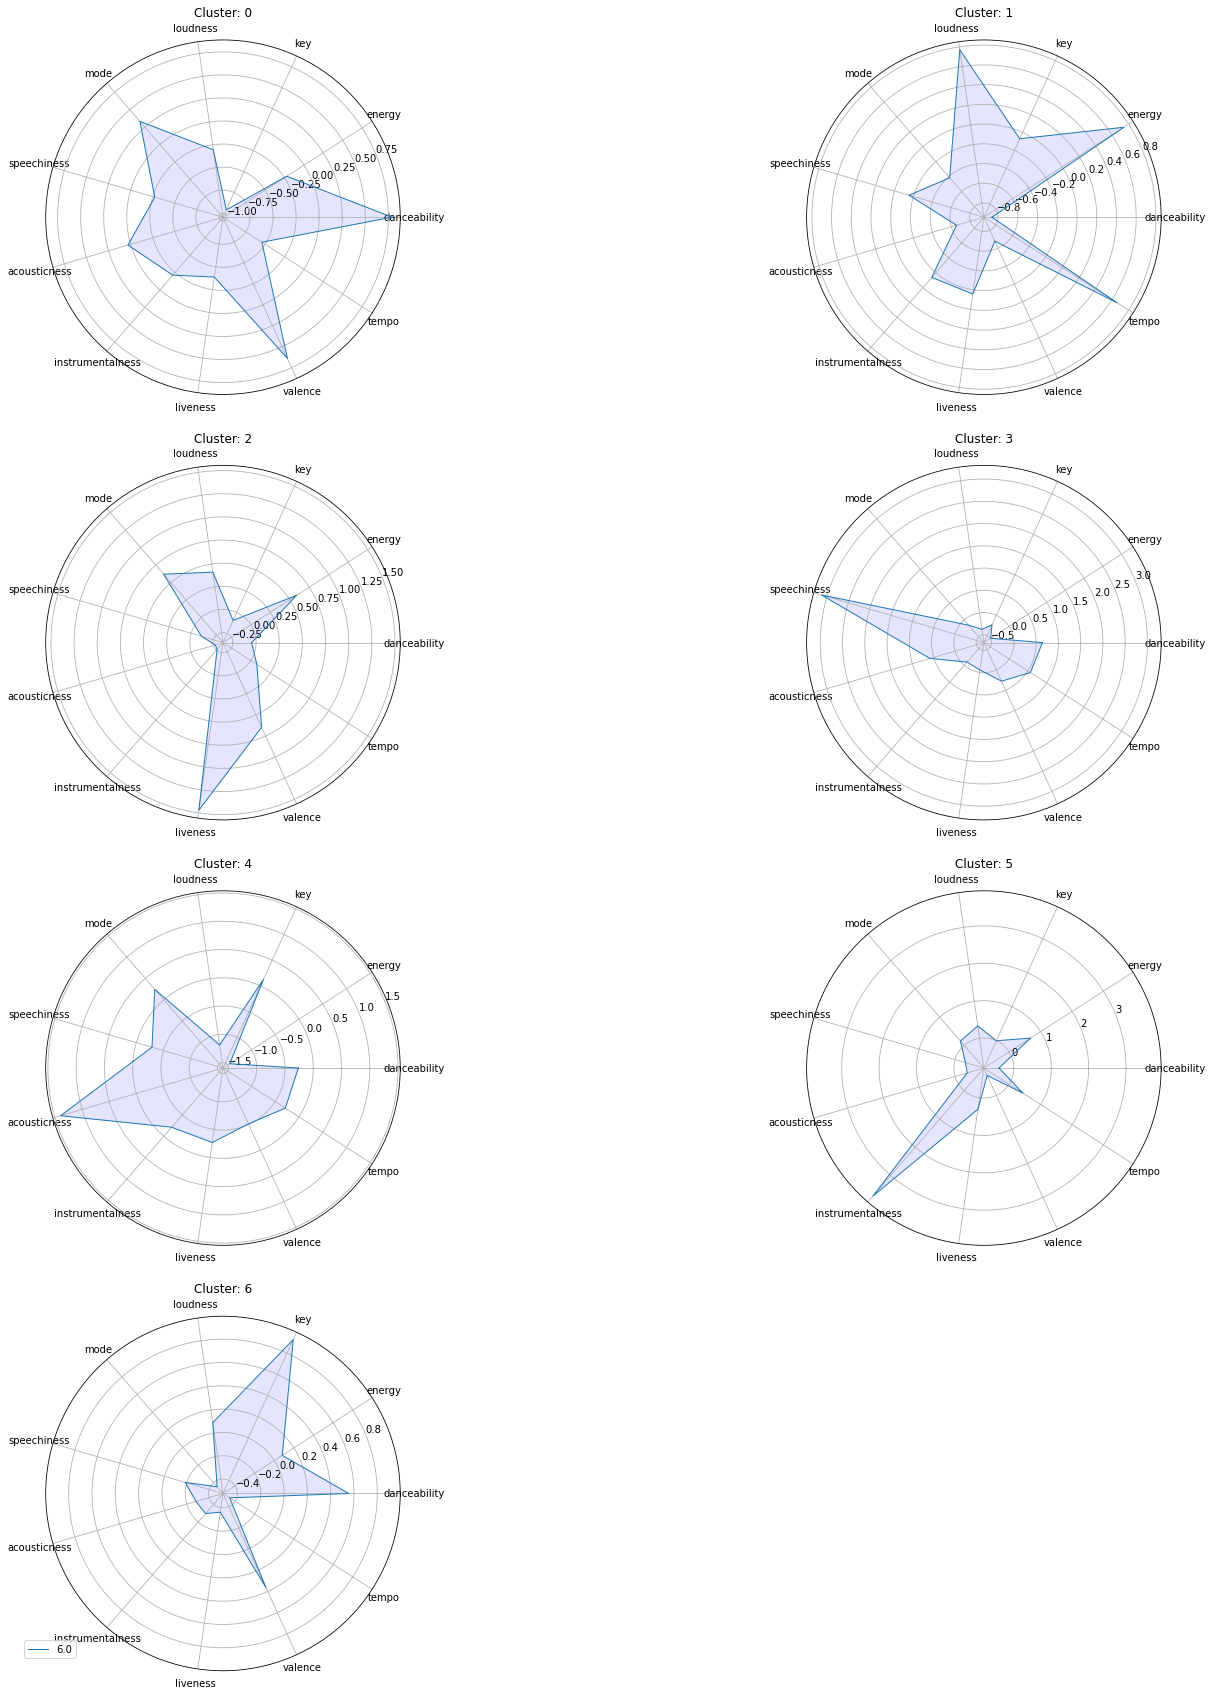

In [456]:
plt.figure(figsize=(25
                    ,30))

for i in range(average_features_by_group.shape[0]):
    values_as_list = average_features_by_group.iloc[i,1:].tolist()
    values_as_list.append(values_as_list[0])
    
    plt.subplot(4,2,i+1,polar=True)
    plt.title('Cluster: '+ str(int(average_features_by_group.iloc[i,0])))
    plt.xticks(angles[:-1], average_features_by_group.iloc[:,1:].columns.tolist())
    
    label_placement = np.linspace(start=0, stop=2*np.pi,num=average_features_by_group.shape[1])
    
    plt.plot(label_placement, values_as_list,linewidth=1, linestyle='solid', label=str(average_features_by_group.iloc[i,0]))
    plt.fill(label_placement,values_as_list,'b',alpha=.1)
    


In [458]:
tracks_with_cluster[tracks_with_cluster['cluster']==5]

,track_id,track_name,track_artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
51,6FYbr9QzRoZPh0Re8lDO9z,7 Minutes,Dean Lewis,-1.112771,1.037901,-0.950081,0.747909,0.733215,-0.100014,-0.898191,4.130814,-0.345752,0.405820,0.931129,5.0
57,41QhRnFDdhMLtR8tmnolbr,WALLS,Kings of Leon,-1.371529,1.517339,-1.228007,1.062327,-1.363856,-0.074386,-0.900839,4.813384,-0.145945,0.718994,1.220995,5.0
119,0ZK8TGOsngrstVPsnrHbK1,Peach Pit,Peach Pit,0.087581,-0.125737,1.551246,0.033961,-1.363856,0.038680,-0.254869,2.487813,0.098264,-0.897661,0.394032,5.0
142,5u9cuDcYdOpSRB7fAYXXdp,Marcel,Her's,-0.077737,0.618392,1.551246,0.424698,0.733215,-0.531169,1.691835,4.656332,-0.561840,1.738926,1.166242,5.0
163,6CDzDgIUqeDY5g8ujExx2f,Heat Waves,Glass Animals,0.360715,0.997947,0.995395,-0.099684,0.733215,-0.589963,-0.419225,5.157689,1.807726,0.249233,0.196857,5.0
196,1kwnxJNVl7cwcU98RvMBaR,Surf,Mac Miller,-0.386810,-0.420392,1.551246,-0.594875,0.733215,0.370338,0.059233,5.157689,-0.538159,0.270393,0.231102,5.0
197,2Yv2mHzr5AQavVdwQjEokV,Hand Me Downs,Mac Miller,-0.645568,0.613398,0.161620,-0.026883,-1.363856,-0.606546,-0.890598,2.620703,0.068663,0.079950,-1.041109,5.0
235,3XstzgzP0rp3bzElEnRVHv,Slow Down,Mac Ayres,1.942017,0.024088,0.439545,-0.154197,0.733215,-0.012576,1.268162,3.653619,-0.449356,0.968687,1.105852,5.0
238,4kHSIZyIEijaMuZpV8GS1p,Who R U?,Anderson .Paak,-0.099300,-0.320509,-1.505932,-0.759470,-1.363856,0.337172,1.096501,3.224747,0.660684,-0.313634,-1.261611,5.0
250,6TqXcAFInzjp0bODyvrWEq,Talk (feat. Disclosure),Khalid,-1.227775,-0.814930,0.717470,-0.666270,0.733215,-0.466345,1.337556,3.665700,-0.790508,-1.401279,-0.224028,5.0
